# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем библиотеки

In [1]:
# Обработка данных
import pandas as pd
import numpy as np

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

### Знакомство с данными

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

geo_data_0.head(), geo_data_1.head(), geo_data_2.head()

(      id        f0        f1        f2     product
 0  txEyH  0.705745 -0.497823  1.221170  105.280062
 1  2acmU  1.334711 -0.340164  4.365080   73.037750
 2  409Wp  1.022732  0.151990  1.419926   85.265647
 3  iJLyR -0.032172  0.139033  2.978566  168.620776
 4  Xdl7t  1.988431  0.155413  4.751769  154.036647,
       id         f0         f1        f2     product
 0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
 1  62mP7  14.272088  -3.475083  0.999183   26.953261
 2  vyE1P   6.263187  -5.948386  5.001160  134.766305
 3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
 4  AHL4O  12.702195  -8.147433  5.004363  134.766305,
       id        f0        f1        f2     product
 0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
 1  WJtFt  0.262778  0.269839 -2.530187   56.069697
 2  ovLUW  0.194587  0.289035 -5.586433   62.871910
 3  q6cA6  2.236060 -0.553760  0.930038  114.572842
 4  WPMUX -0.515993  1.716266  5.899011  149.600746)

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек;
* product — объём запасов в скважине (тыс. баррелей).

In [3]:
geo_data_0.info()
print('----------------------------------------------------')
geo_data_1.info()
print('----------------------------------------------------')
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
----------------------------------------------------
<class 'pandas.core.frame.

In [4]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Обработка данных

In [7]:
# Удалим столбец id

geo_data_0 = geo_data_0.drop(columns=['id'])
geo_data_1 = geo_data_1.drop(columns=['id'])
geo_data_2 = geo_data_2.drop(columns=['id'])

Поиск дубликатов

In [8]:
geo_data_0.duplicated().sum()

0

In [9]:
geo_data_1.duplicated().sum()

0

In [10]:
geo_data_2.duplicated().sum()

0

## Обучение и проверка модели

* **Для обучения будем использовать модель "Линейной регрессии".**
* **Разобьём данные на обучающую и валидационную выборки в соотношении 75:25**
* **Проанализируем средний запас предсказанного сырья и RMSE модели.**

In [11]:
STATE = np.random.RandomState(12345)

### Регион №1

In [12]:
target_0 = geo_data_0['product']
features_0 = geo_data_0.drop('product', axis=1)
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=STATE)

model = LinearRegression()
model.fit(features_train_0, target_train_0)
predicted_valid_0 = model.predict(features_valid_0)
mse = mean_squared_error(target_valid_0, predicted_valid_0)

print('RMSE:', mse**0.5)
print('Средний предсказанный запас:', predicted_valid_0.mean())
print('Средний реальный запас:', target_valid_0.mean())

RMSE: 37.5794217150813
Средний предсказанный запас: 92.59256778438035
Средний реальный запас: 92.07859674082927


### Регион №2

In [13]:
target_1 = geo_data_1['product']
features_1 = geo_data_1.drop('product', axis=1)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=STATE)

model = LinearRegression()
model.fit(features_train_1, target_train_1)
predicted_valid_1 = model.predict(features_valid_1)
mse = mean_squared_error(target_valid_1, predicted_valid_1)

print('RMSE:', mse**0.5)
print('Средний предсказанный запас:', predicted_valid_1.mean())
print('Средний реальный запас:', target_valid_1.mean())

RMSE: 0.889736773768065
Средний предсказанный запас: 68.76995145799754
Средний реальный запас: 68.77162424984647


### Регион №3

In [14]:
target_2 = geo_data_2['product']
features_2 = geo_data_2.drop('product', axis=1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=STATE)

model = LinearRegression()
model.fit(features_train_2, target_train_2)
predicted_valid_2 = model.predict(features_valid_2)
mse = mean_squared_error(target_valid_2, predicted_valid_2)

print('RMSE:', mse**0.5)
print('Средний предсказанный запас:', predicted_valid_2.mean())
print('Средний реальный запас:', target_valid_2.mean())

RMSE: 39.958042459521614
Средний предсказанный запас: 95.087528122523
Средний реальный запас: 94.74895871720241


**Вывод:** Хороший результат RMSE:0.89 показывает Регион№2, к сожалению данный регион с самым низким среднем показателем запаса сырья 68.76. У Регион№1 и Регион№3 предсказанный запас сырья 92.59 и 94.96 соответственно, но сильно большой позатель RMSE №1: 37.57 и RMSE №3: 40.02.

## Подготовка к расчёту прибыли

In [15]:
# Запишем все ключевые значения для расчётов в отдельные переменные

POINTS = 500
BEST_POINTS = 200
BUDGET = 10e9
PRICE_ONETHOUSAND_BARREL = 450000

In [16]:
# Расчитаем достаточный объём сырья для безубыточной разработки новой скважины.

threshold_barrel = BUDGET / (PRICE_ONETHOUSAND_BARREL) / BEST_POINTS
print('Объём сырья для безубыточной разработки:', round(threshold_barrel, 2))

Объём сырья для безубыточной разработки: 111.11


Минимальный объем сырья должен составлять 111.11 тыс. баррелей, при этом с нашим среднем предсказанным объемом не дотягиваем и до 100, а регион который показал самый лучший результат RMSE:0.89 и того средний запас составляет 68.72 тыс. баррелей. 

## Расчёт прибыли и рисков 

In [17]:
def revenue(target, predictions):
    
    """Функция находит 200 лучших скважин и считает прибыль"""
    
    pred_sorted = pd.Series(predictions).sort_values(ascending=False)
    profit = target.iloc[pred_sorted.index][:BEST_POINTS]
    return profit.sum() * PRICE_ONETHOUSAND_BARREL - BUDGET

In [18]:
def profit(targets, predict):
    
    """Функция для подсчета ср. прибыли, 95%-й доверительный интервал  и риск убытков,
    для выбранных скважин, в которой сгенерируем 1000 выборок."""  

    values = []
    for i in range(1000):
        predict_subsample = pd.Series(predict).sample(n=POINTS, replace=True, random_state=STATE)
        values.append(revenue(targets,predict_subsample))
        
    values = pd.Series(values)
    confidence_interval = (values.quantile(0.025),values.quantile(0.975)) 
    
    print('Cредняя прибыль:', values.mean())
    print('Доверительный интервал:', confidence_interval)
    print('Риск убытков:', (values < 0).mean())
    sns.boxplot(x=values, orient='h', width=0.3)

Cредняя прибыль: 394284411.3405507
Доверительный интервал: (-69450566.85672115, 915496165.8311511)
Риск убытков: 0.061


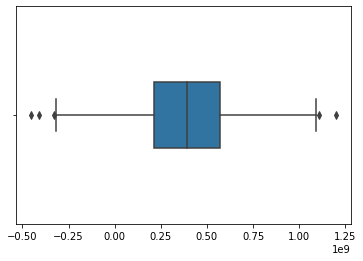

In [19]:
profit(target_valid_0, predicted_valid_0)

Cредняя прибыль: 454736359.0973578
Доверительный интервал: (61071811.297698975, 855914149.1428356)
Риск убытков: 0.007


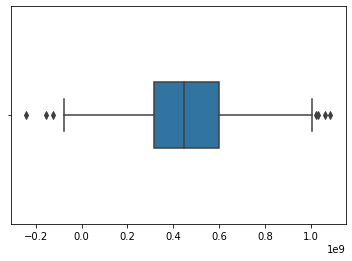

In [20]:
profit(target_valid_1, predicted_valid_1)

Cредняя прибыль: 353664097.5248346
Доверительный интервал: (-162650946.9422927, 847761844.5147682)
Риск убытков: 0.076


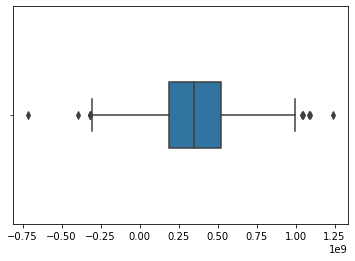

In [21]:
profit(target_valid_2, predicted_valid_2)

**Вывод:** И так, задачей данного проекта было определить самый прибыльный регион из трех доступных для бурения новых скважин.
Для начала мы предсказали средний объём по каждому региону, воспользовавшись моделью Линейной регрессии. Определили качество модели с помощью **RMSE**. И получили следующие результаты.

* Регион №1: RMSE = 37.77, Средний предсказанный запас = 92 и Средний реальный запас = 92.
* Регион №2: RMSE = 0.88, Средний предсказанный запас = 68 и Средний реальный запас = 68.
* Регион №3: RMSE = 40.03, Средний предсказанный запас = 94 и Средний реальный запас = 94.

По расчетам,  для безубыточной разработки новой скважины минимальный объем должен был составлять 111.11 тыс. баррелей. 
При условии, что на разработку в регионе бюджет составляет 10 млдр. руб.. А стоимость  1 тыс. баррелей при нынешнией цене 450 тыс. рублей. Для расчета прибыли мы взяли 200 лучших скважин, самым большим объемом сырья.  
Мы рассчитали среднею прибыль, доверительный интервал и риски убытков для каждого региона. 

* Регион №1: 
        Cредняя прибыль 200 лучших скважин составила 0.39 млрд. руб.
        Доверительный интервал: (-93919399.11819586, 935053013.565755)
        Риск убытков: 5%
* Регион №2:
        Cредняя прибыль 200 лучших скважин составила 0.43 млрд. руб.
        Доверительный интервал: (39620643.840192705, 854519317.8844535)     
        Риск убытков: 1%
* Регион №3:
        Cредняя прибыль 200 лучших скважин составила 0.34 млрд. руб.
        Доверительный интервал: (-166403223.3065491, 815158158.1911238)
        Риск убытков: 9%

Подводя итоги, рекомендованный Регон№2, т.к. средняя прибыль составила 0.43 млрд. руб. и положительный доверительный интервал. Риск убытков при этом всего 1%.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован